## Benign T cells analysis

We subset to benign T cells and explore their heterogeneity.

__author__ = "Ciro Ramírez-Suástegui"

__license__ = "GPL"

__version__ = "0.0.9"

__status__ = "Prototype"

__copyright__ = "Copyright 2024-06-24, The Wellcome Sanger Institute"

__email__ = "cs59@sanger.ac.uk, cramsuig@gmail.com"

__creation__ = "2024-06-24 Mon 11:23:47 BST"

__updated__ = "2024-07-05"

#### Structure <a class="anchor" id="menu"></a>

* [Global variables and paths](#bullet1)
* [Loading data](#bullet2)
* [Pre-processing](#bullet3)
* [Main](#bullet4)
* [Conclusions](#bullet5)
* [Save](#bullet6)

### Environment setup

Dependencies: functions and packages

In [1]:
import importlib.util as importlib_util
is_pynb = importlib_util.find_spec("get_ipython")
if is_pynb is not None:
    %load_ext autoreload
    %autoreload 2

In [2]:
style = importlib_util.find_spec("lab_black")
if is_pynb is not None and style is not None:
        %load_ext lab_black

In [3]:
# basic modules
import warnings, os, sys, re, time
import inspect, pickle
import logging
logging.basicConfig(level=logging.INFO)

In [4]:
# Script's directory
try:
    __file__
except NameError:
  temp=!echo $(pwd)
  __file__=temp[0]

In [5]:
project_dir = os.path.dirname(os.path.realpath(__file__))
if os.path.basename(project_dir) != os.path.basename(os.getcwd()):
    os.chdir(project_dir)

In [6]:
warnings.simplefilter(action="ignore", category=FutureWarning)
warnings.simplefilter(action="ignore", category=UserWarning)

In [7]:
# in-house/developing modules
import datetime
def tstamp(fname, fmt='{fname}_%Y%m%d-%H%M%S'):
    return datetime.datetime.now().strftime(fmt).format(fname=fname)

In [8]:
# tools modules
import numpy as np
import pandas as pd
import scanpy as sc
import matplotlib.pyplot as plt
import matplotlib.figure as mplfig # to check for Figure type

In [9]:
if is_pynb is not None:
    !echo "${HOSTNAME} | ${SLURMD_NODENAME} ${PBS_NODEFILE}"
homename = os.environ.get('USER', os.environ.get('USERNAME'))
logging.info(f'Environment: {re.sub(".*"+homename+"|.os.py", "", os.__file__)}')
logging.info(f'Working at: {re.sub(".*"+homename, "", os.getcwd())}')

INFO:root:Environment: /software/team152/cs57/mambaforge/envs/scanpy/lib/python3.10
INFO:root:Working at: /lustre/scratch126/cellgen/team298/projects/ctcl


### [Global variables and paths](#menu) <a class="anchor" id="bullet1"></a>

In [10]:
# inputs_file = "/lustre/scratch126/cellgen/team298/ab72/CTCL/objects-new" +\
#               "/all_samples_scvi_4kbydonor_6dim_100hidd" +\
#               "_leiden_broad_ct_mastcell_corrected_celltypist.h5ad"
inputs_file = "/lustre/scratch126/cellgen/team205/rl20/CTCL/object_revision/CTCL_all_final_20240707.h5ad"
inputs_tcel = "/lustre/scratch126/cellgen/team205/rl20/CTCL/object_revision/" +\
              "skin_atlas_ctcl_benign_Tcell_20240707.h5ad"
output_file = "data/atlas_subset-tcells_benign.h5ad"
output_dir = "results/atlas_subset-tcells_benign"
figure_dir = "figures/atlas_subset-tcells_benign"

In [11]:
OUTPUTS = dict()

#### Visualisation parameters

In [12]:
rcParams_dict = {
  "figure.figsize": (7, 7), "figure.dpi": 150, "figure.frameon": False,
  "savefig.dpi": 190, "savefig.bbox": "tight", "savefig.transparent": True
}
for i in rcParams_dict.keys():
  print(i.ljust(22, ' '), plt.rcParams[i], end=" > ")
  plt.rcParams[i] = rcParams_dict[i]
  print(plt.rcParams[i])

figure.figsize         [6.4, 4.8] > [7.0, 7.0]
figure.dpi             100.0 > 150.0
figure.frameon         True > False
savefig.dpi            figure > 190.0
savefig.bbox           None > tight
savefig.transparent    False > True


#### Scanpy settings and logging

In [13]:
sc.logging.print_versions()

-----
anndata     0.10.6
scanpy      1.10.0rc2.dev29+gc68557c5
-----
PIL                 10.3.0
asciitree           NA
asttokens           NA
cloudpickle         3.0.0
colorama            0.4.6
comm                0.2.2
cycler              0.12.1
cython_runtime      NA
cytoolz             0.12.3
dask                2024.4.0
dateutil            2.9.0
debugpy             1.8.1
decorator           5.1.1
exceptiongroup      1.2.0
executing           2.0.1
h5py                3.10.0
igraph              0.11.4
ipykernel           6.29.3
jedi                0.19.1
jinja2              3.1.3
joblib              1.3.2
kiwisolver          1.4.5
legacy_api_wrap     NA
leidenalg           0.10.2
llvmlite            0.42.0
lz4                 4.3.3
markupsafe          2.1.5
matplotlib          3.8.3
mpl_toolkits        NA
msgpack             1.0.7
natsort             8.4.0
numba               0.59.1
numcodecs           0.12.1
numpy               1.26.4
packaging           24.0
pandas              2.

In [14]:
sc.settings.figdir = figure_dir

### [Loading data](#menu) <a class="anchor" id="bullet2"></a>

In [15]:
adata0 = sc.read(inputs_file, backed="r")

In [16]:
adata0

AnnData object with n_obs × n_vars = 419579 × 15790 backed at '/lustre/scratch126/cellgen/team205/rl20/CTCL/object_revision/CTCL_all_final_20240707.h5ad'
    obs: 'Sanger_ID', 'tissue', 'site', 'Sex', 'batch', 'n_counts', 'n_genes', 'percent_mito', 'study', 'donor', 'tech', 'cell_type', 'barcode', 'type'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'broad_ct_colors', 'cell_type_colors', 'donor_colors', 'groups1_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'tech_colors'
    obsm: 'X_scVI', 'X_scVI_MDE', '_scvi_extra_categorical_covs'
    layers: 'raw_counts'
    obsp: 'connectivities', 'distances'

In [18]:
adata0.obs["study"].value_counts()

study
8_CTCL    277158
HRJ        60164
NC         49634
prj        32623
Name: count, dtype: int64

In [19]:
adata0.obs["tech"].value_counts()

tech
10x     369945
flex     49634
Name: count, dtype: int64

In [20]:
pd.crosstab(adata0.obs["study"], adata0.obs["tech"])

tech       10x   flex
study                
8_CTCL  277158      0
HRJ      60164      0
NC           0  49634
prj      32623      0

In [21]:
pd.crosstab(adata0.obs["donor"], adata0.obs["tech"])

tech               10x   flex
donor                        
CTCL1            21684      0
CTCL2            13570      0
CTCL3            26623      0
CTCL4            25187      0
CTCL5            41201      0
CTCL6            37073      0
CTCL7            77712      0
CTCL8            34108      0
MF14              5314      0
MF15              2393      0
MF17              6768      0
MF18              1730      0
MF21              3722      0
MF22              2039      0
MF26              2124      0
MF27              1958      0
MF28             19639      0
MF30             14477      0
PR001409E_18_1A      0   5984
PR2533_18_1A         0   2312
PR004642T_15_1A      0    799
PR008096T_19_1A      0   7426
PR018817H_21_1B      0  16744
PR030476F_16_1A      0   1359
PR037703E_16_2A      0    458
PR038176R_19_1A      0   3775
PR824258V_20_2A      0    695
PR839543V_20_1A      0  10082
PT11              4288      0
PT35              6522      0
PT47               908      0
PT50              5161      0
PT52               479      0
PT53              3142      0
PT55              3297      0
PT56              8826      0

In [15]:
adatat = sc.read(inputs_tcel, backed="r")

In [16]:
adatat

AnnData object with n_obs × n_vars = 229915 × 15777 backed at '/lustre/scratch126/cellgen/team205/rl20/CTCL/object_revision/skin_atlas_ctcl_benign_Tcell_20240707.h5ad'
    obs: 'batch', 'n_counts', 'n_genes', 'percent_mito', 'donor', 'tech', 'sample_type', 'groups1', 'groups', 'broad_ct', 'ctpredicted_labels', 'ctover_clustering', 'ctmajority_voting', 'ctconf_score', 'cell_type', 'site', 'tissue', 'Sex', 'type'
    var: 'genes', 'gene_ids'
    uns: '_scvi_manager_uuid', '_scvi_uuid', 'cell_type_colors', 'ctmajority_voting_colors', 'groups1_colors', 'hvg', 'leiden', 'log1p', 'neighbors', 'over_clustering', 'sample_type_colors', 'site_colors', 'tech_colors', 'tissue_colors', 'type_colors'
    obsm: 'X_scVI', 'X_scVI_MDE', '_scvi_extra_categorical_covs'
    layers: 'raw_counts'
    obsp: 'connectivities', 'distances'

In [17]:
adata = adatat.to_memory()

In [18]:
adata.obs["site"].value_counts()

site
lesion        168430
non_lesion     61485
Name: count, dtype: int64

### [Pre-processing](#menu) <a class="anchor" id="bullet3"></a>

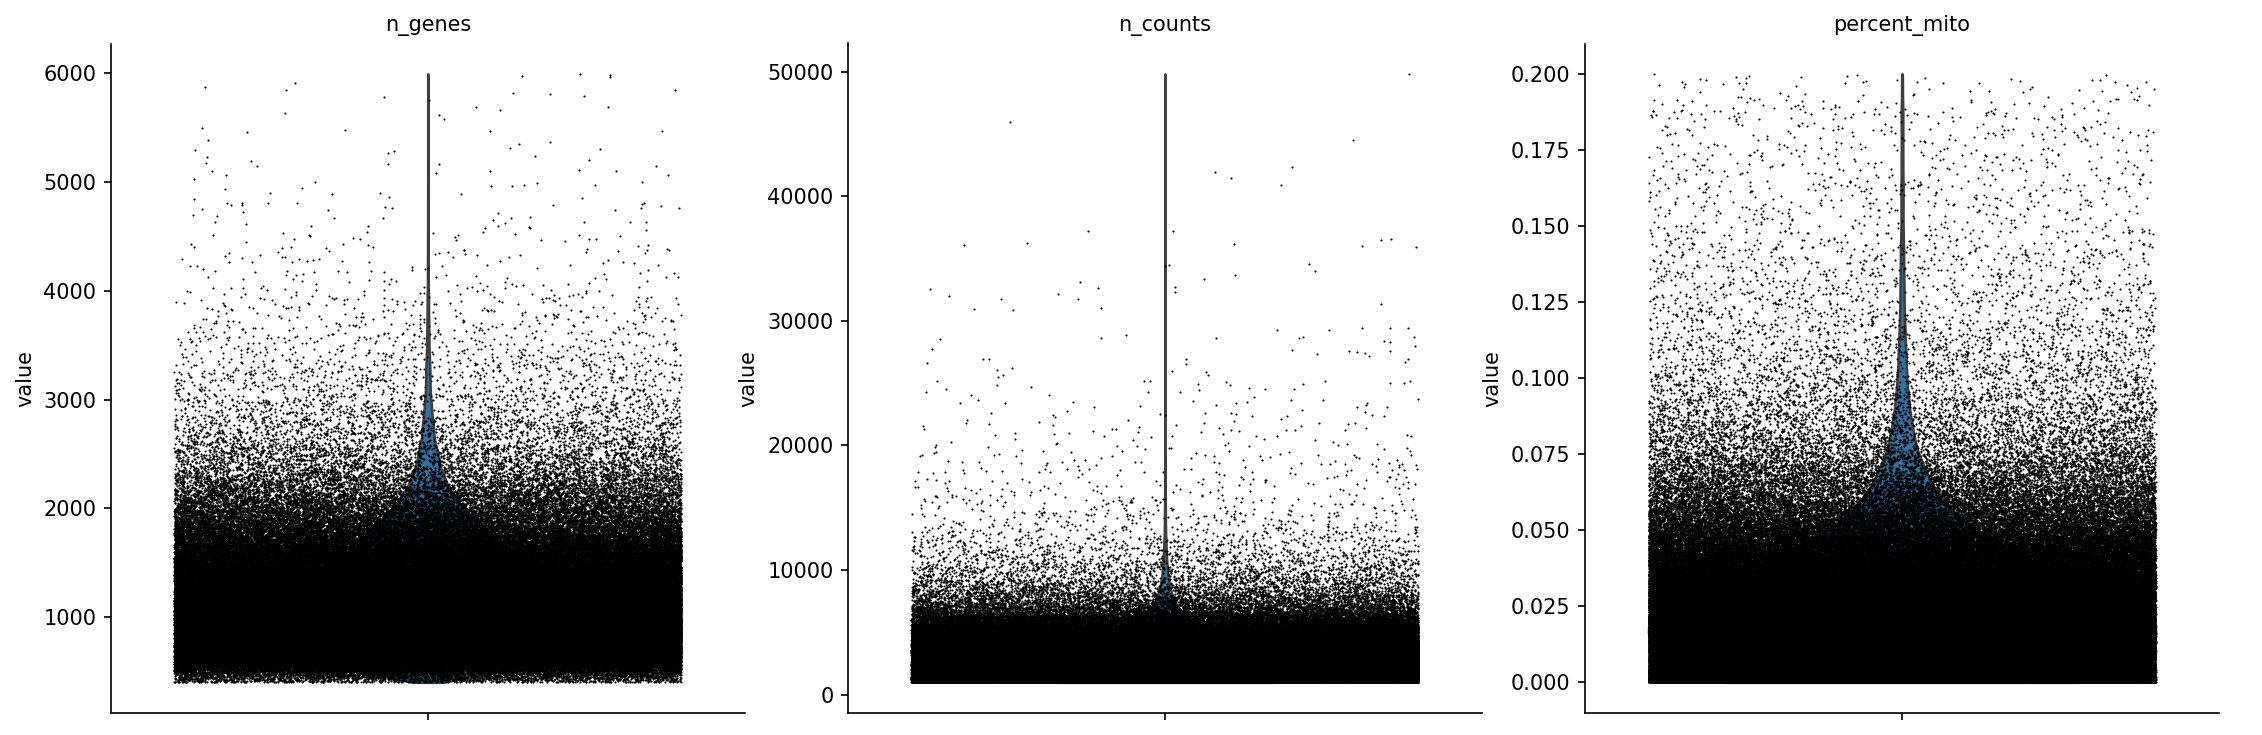

In [19]:
sc.pl.violin(
    adatat,
    ["n_genes", "n_counts", "percent_mito"],
    jitter=0.4,
    multi_panel=True,
)

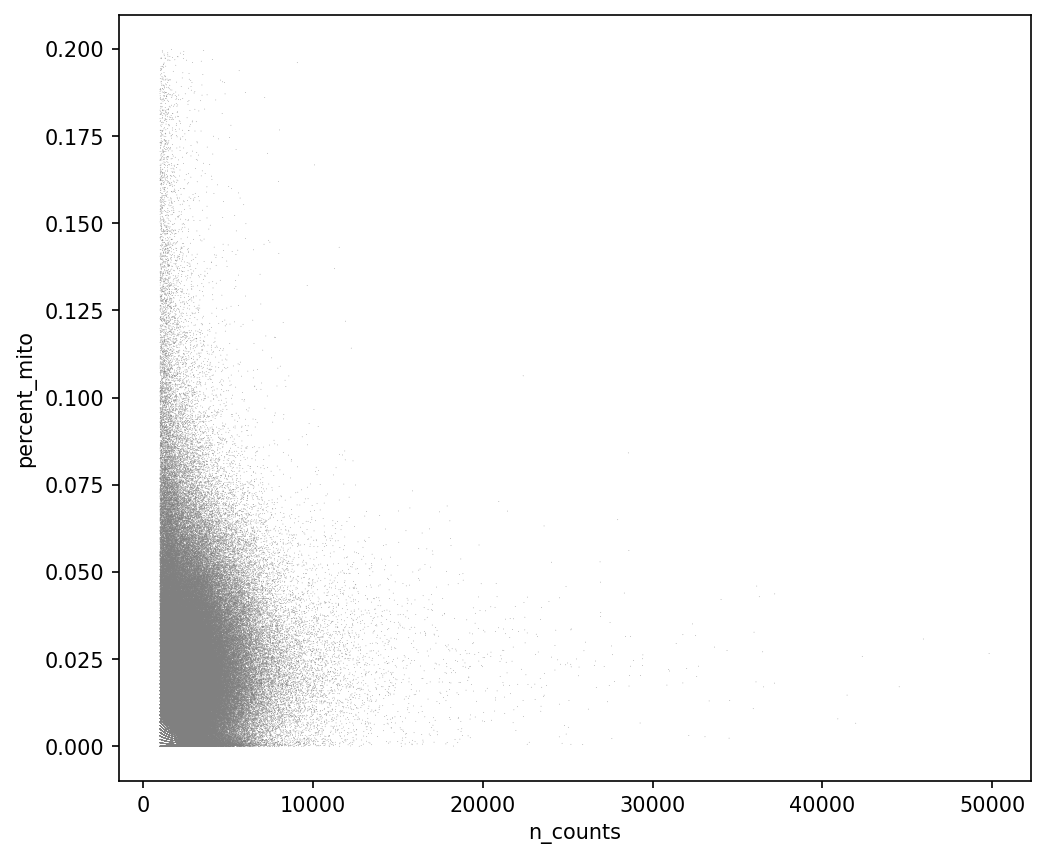

In [20]:
sc.pl.scatter(adatat, x="n_counts", y="percent_mito")

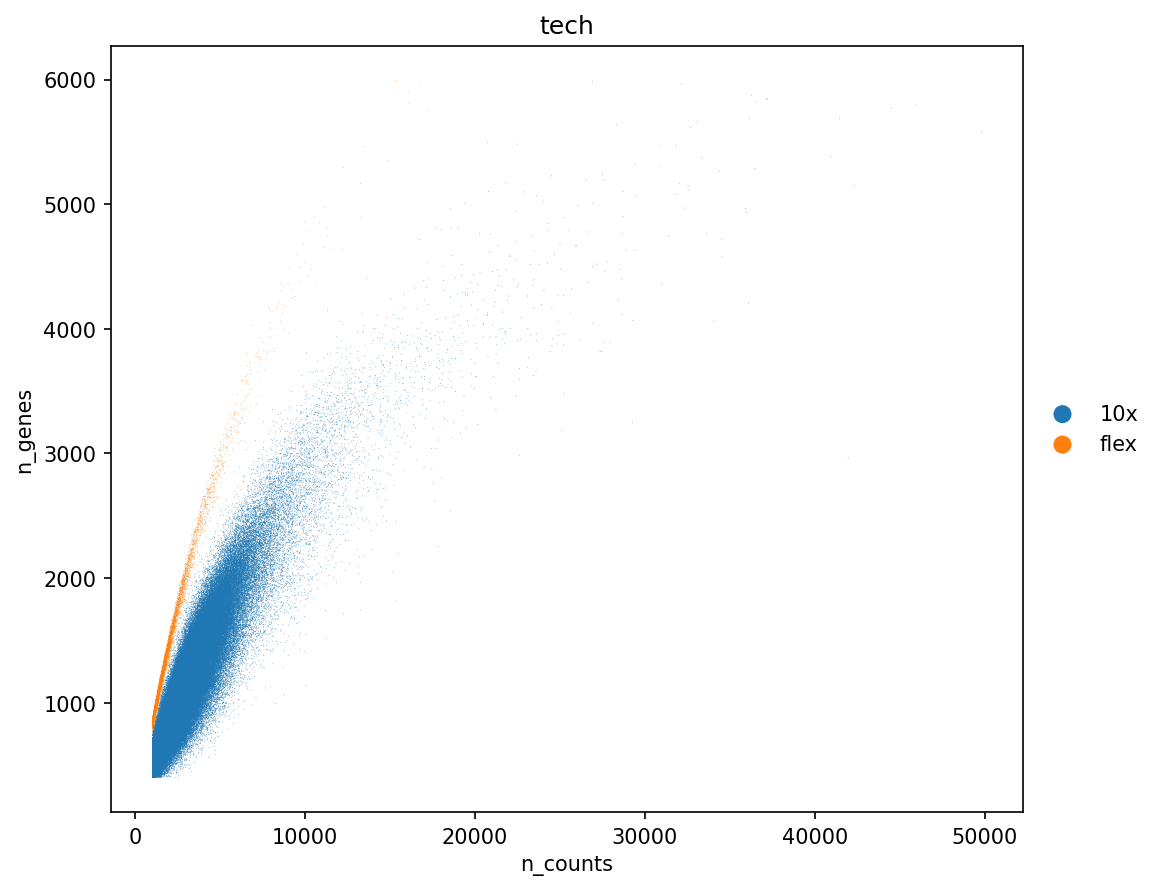

In [21]:
sc.pl.scatter(adatat, color="tech", x="n_counts", y="n_genes")

In [22]:
print("Is adata.raw present?", adata.raw is not None)

Is adata.raw present? False


In [23]:
adata.X[:10,:10].A

array([[0.        , 0.        , 0.        , 0.        , 0.        ,
        2.1644833 , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        1.49198218, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 2.00120329, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.        , 0.        , 0.        ,
        2.06522247, 0.        , 0.        , 0.        , 0.        ],
       [0.        , 1.93806563, 0.        , 0.        , 0.        ,
        0.        , 0.        , 0.        , 0.        , 0.        ],
       [0.        , 0.        , 0.       

In [24]:
pd.Series(adata.X[:,1:100].A.flatten()).value_counts()

0.000000    21417775
2.364921         695
2.325677         659
2.390654         648
2.188736         647
              ...   
3.681481           1
4.195444           1
4.550898           1
3.659629           1
3.914820           1
Name: count, Length: 38400, dtype: int64

Looks normalised.

### [Main](#menu) <a class="anchor" id="bullet4"></a>

In [25]:
%%time
sc.pp.neighbors(adata, n_neighbors=50, use_rep="X_scVI")

/software/team152/cs57/mambaforge/envs/scanpy/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


CPU times: user 1min 54s, sys: 8.47 s, total: 2min 2s
Wall time: 2min 4s


In [26]:
%%time
sc.tl.umap(adata)

CPU times: user 7min 17s, sys: 7.19 s, total: 7min 24s
Wall time: 7min 26s


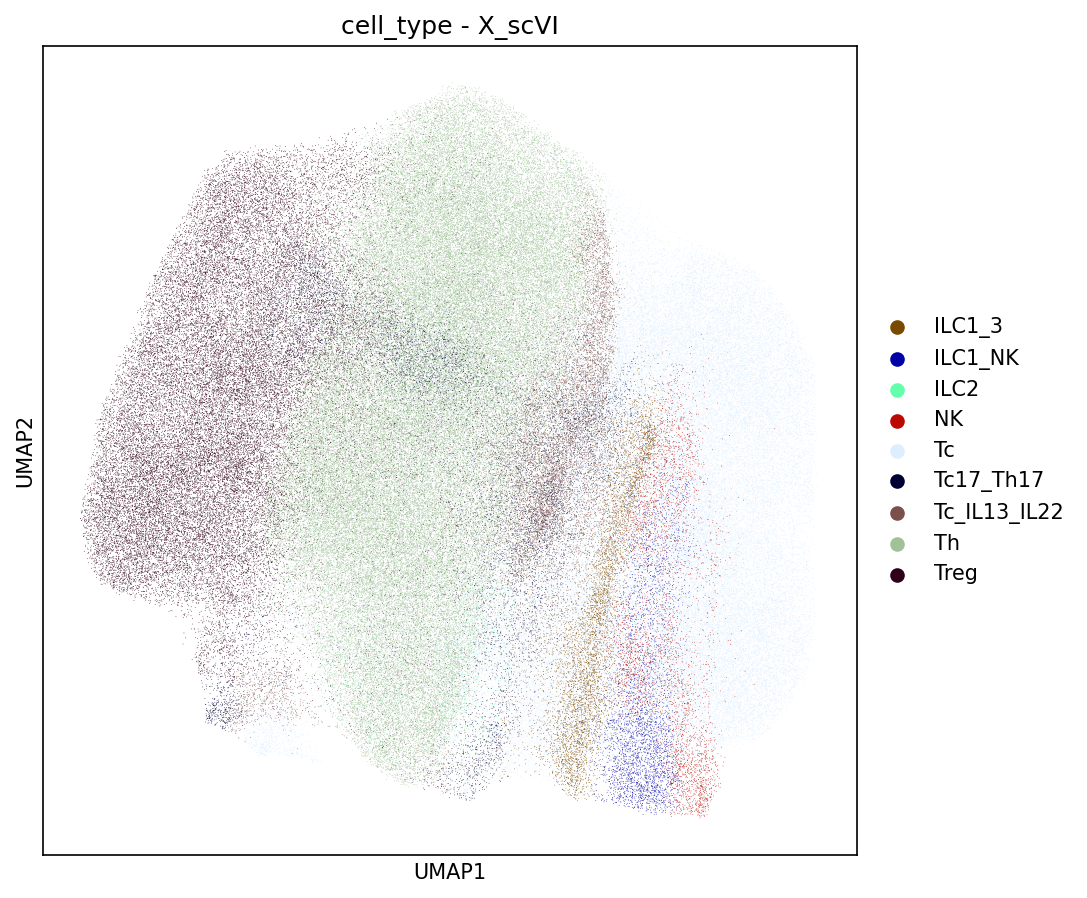

In [27]:
i = "cell_type"
fname = "umap_" + i + "_box"
OUTPUTS[fname] = sc.pl.umap(
    adata, color=i, title=i + " - X_scVI", return_fig=True
);

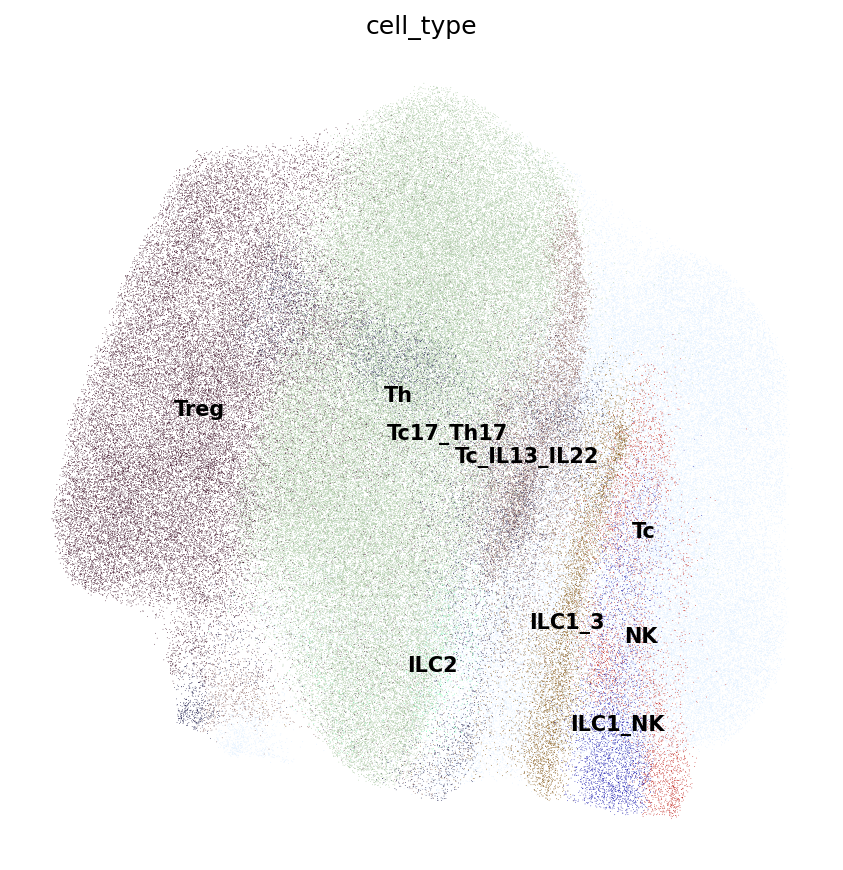

In [28]:
# plt.rcParams["font.size"] = 10
i = "cell_type"
fname = "umap_" + i
OUTPUTS[fname] = sc.pl.umap(
    adata, color=i, frameon=False,
    legend_loc='on data', title=None,
    return_fig=True
);
plt.rcParams["font.size"] = 10

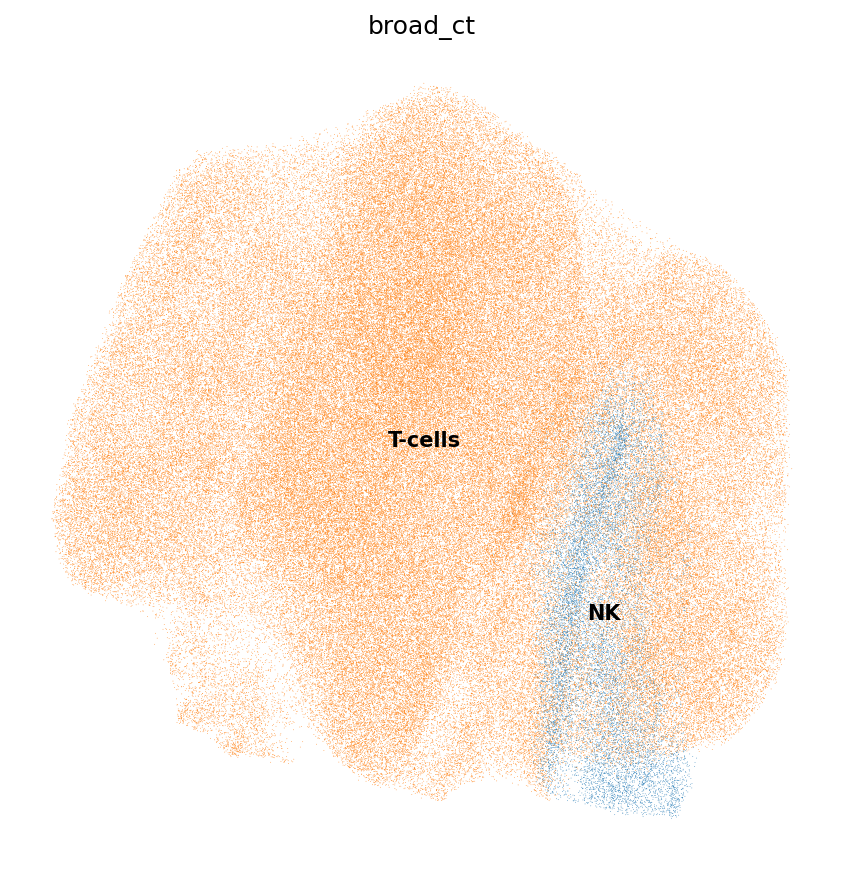

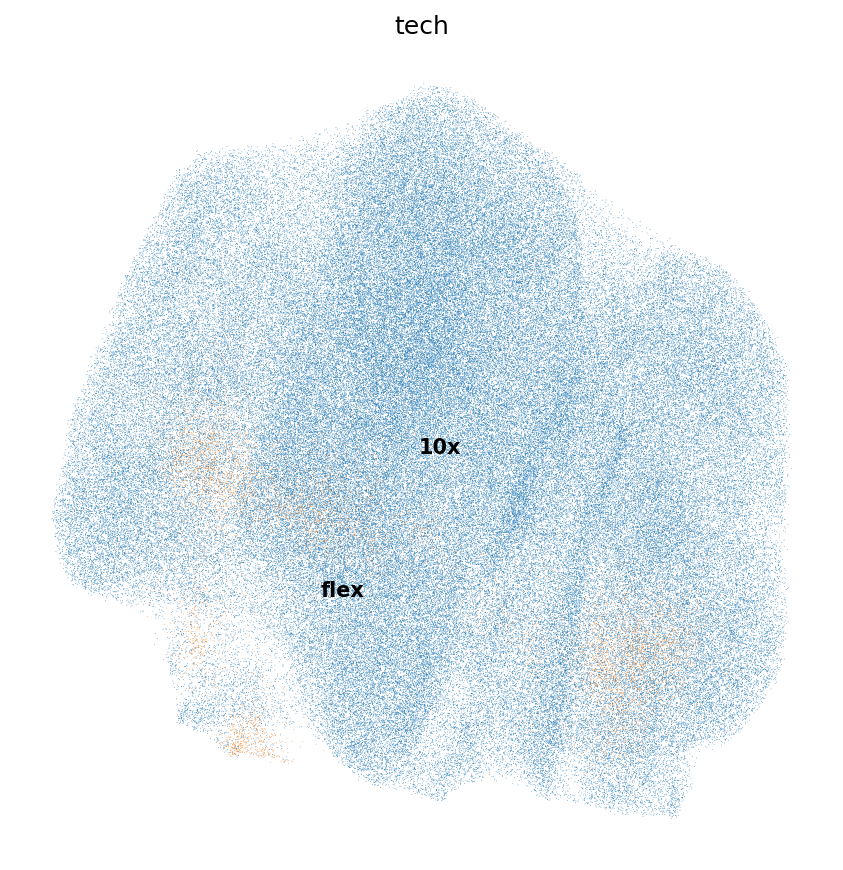

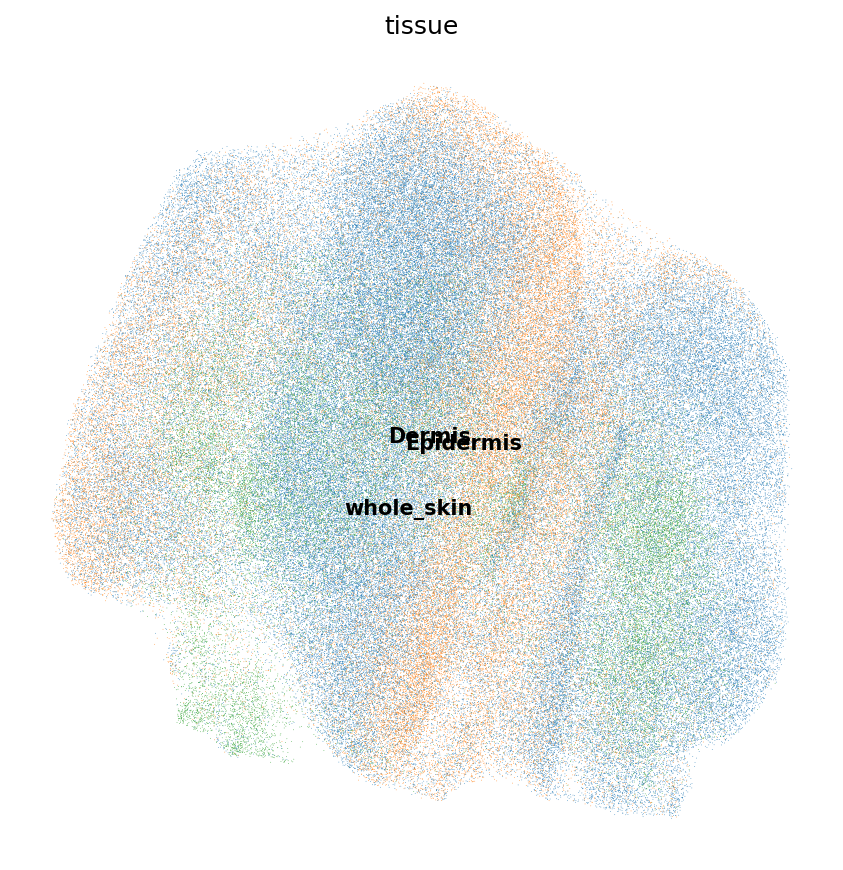

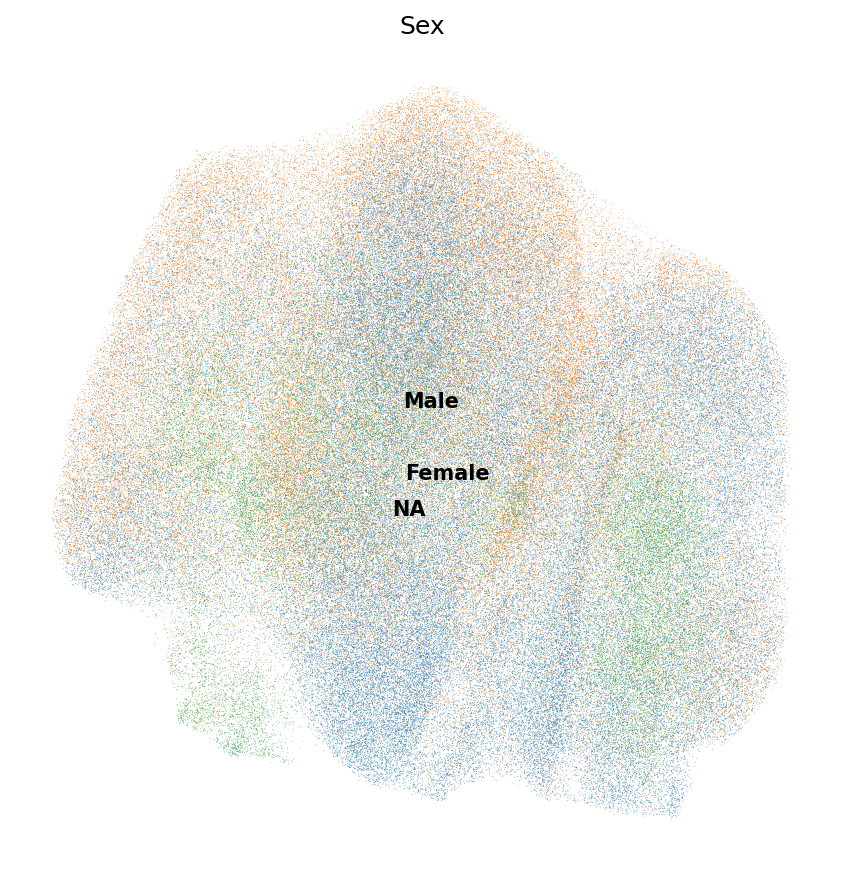

In [29]:
for i in ["broad_ct", "tech", "tissue", "Sex"]:
    fname = "umap_" + i
    OUTPUTS[fname] = sc.pl.umap(
        adata, color=i, frameon=False,
        legend_loc='on data', title=None,
        return_fig=True
    );

### [Conclusions](#menu) <a class="anchor" id="bullet5"></a>

In [30]:
OUTPUTS.keys()

dict_keys(['umap_cell_type_box', 'umap_cell_type', 'umap_broad_ct', 'umap_tech', 'umap_tissue', 'umap_Sex'])

### [Save](#menu) <a class="anchor" id="bullet6"></a>

In [31]:
figure_dir_stamp = tstamp(figure_dir, fmt="{fname}_%Y%m%d")
output_dir_stamp = tstamp(output_dir, fmt="{fname}_%Y%m%d")

In [32]:
for i in [figure_dir_stamp, output_dir_stamp]:
    print(i)
    if not os.path.isdir(i):
        os.makedirs(i)

figures/atlas_subset-tcells_benign_20240710
results/atlas_subset-tcells_benign_20240710


In [33]:
adata.write(output_file)

In [34]:
pflag = " \033[1;32m√\033[0m"
for filename0, item in OUTPUTS.items():
    filename = tstamp(filename0, fmt="%H%M_nn15_{fname}")
    if isinstance(item, (pd.DataFrame, dict)):
        fname = os.path.join(output_dir_stamp, f"{filename}")
    else:
        fname = os.path.join(figure_dir_stamp, f"{filename}")
    print("Storing", type(item), fname, end="");
    eflag = " \033[1;31mX\033[0m"
    if not os.path.isdir(os.path.dirname(fname)):
        os.makedirs(os.path.dirname(fname)); eflag = pflag
    # file type
    if isinstance(item, (mplfig.Figure, tuple)):
        (item[0] if isinstance(item, tuple) else item).savefig(f"{fname}.png")
        plt.close(); eflag = pflag
    elif isinstance(item, pd.DataFrame):
        item.to_csv(f"{fname}.csv"); eflag = pflag
    elif isinstance(item, dict):
        with open(f"{fname}.pickle", 'wb') as handle:
            pickle.dump(item, handle, protocol=pickle.HIGHEST_PROTOCOL)
        eflag = pflag
    elif item is not None:
        item.savefig(f"{fname}.png")
        plt.close(); eflag = pflag
    print(f"{eflag}")

Storing <class 'matplotlib.figure.Figure'> figures/atlas_subset-tcells_benign_20240710/1614_nn15_umap_cell_type_box √
Storing <class 'matplotlib.figure.Figure'> figures/atlas_subset-tcells_benign_20240710/1614_nn15_umap_cell_type √
Storing <class 'matplotlib.figure.Figure'> figures/atlas_subset-tcells_benign_20240710/1614_nn15_umap_broad_ct √
Storing <class 'matplotlib.figure.Figure'> figures/atlas_subset-tcells_benign_20240710/1614_nn15_umap_tech √
Storing <class 'matplotlib.figure.Figure'> figures/atlas_subset-tcells_benign_20240710/1614_nn15_umap_tissue √
Storing <class 'matplotlib.figure.Figure'> figures/atlas_subset-tcells_benign_20240710/1614_nn15_umap_Sex √


Done.